# Reformatting Ubuntu Dialogue Corpus for Chatbot Model

## Dataset Description

Random facts [from paper](https://arxiv.org/abs/1506.08909):
* 2-way (dyadic) conversation, as opposed to multi-participant.


## Load the Data

In [1]:
import numpy as np
import os.path
import pdb
import pandas as pd
from pprint import pprint

DATA_DIR = '/home/brandon/terabyte/Datasets/ubuntu_dialogue_corpus/'
TRAIN_PATH = DATA_DIR + 'src/train.csv'
VALID_PATH = DATA_DIR + 'src/valid.csv'
TEST_PATH = DATA_DIR + 'src/test.csv'

def get_training():
    """Returns dataframe data from train.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_train = pd.read_csv(TRAIN_PATH)
    # Remove all examples with label = 0. (why would i want to train on false examples?)
    df_train = df_train.loc[df_train['Label'] == 1.0]
    # Don't care about the pandas indices in the df, so remove them.
    df_train = df_train.reset_index(drop=True)
    df_train = df_train[df_train.columns[:2]]
    return df_train

def get_validation():
    """Returns data from valid.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_valid = pd.read_csv(VALID_PATH)
    first_two_cols = df_valid.columns[:2]
    df_valid = df_valid[first_two_cols]
    df_valid.columns = ['Context', 'Utterance']
    return df_valid

df_train = get_training()
df_valid = get_validation()

## Functions for Visualization and Reformatting

In [66]:
# Now get all of the data in a single string and make a 'vocabulary' (unique words). 
import nltk, re, pprint
from nltk import word_tokenize
import pdb

def print_single_turn(turn: str):
    as_list_of_utters = turn.split('__eou__')[:-1]
    for idx_utter, utter in enumerate(as_list_of_utters):
        print("\t>>>", utter)

def print_conversation(df, index=0):
    """Display the ith conversation in nice format."""
    
    # Get the row identified by 'index'. 
    context_entry = df['Context'].values[index]
    target        = df['Utterance'].values[index]
    
    # Split returns a blank last entry, so don't store.
    turns = context_entry.split('__eot__')[:-1]
    print('--------------------- CONTEXT ------------------- ')
    for idx_turn, turn in enumerate(turns):
        print("\nUser {}: ".format(idx_turn % 2))
        print_single_turn(turn)
    print('\n--------------------- RESPONSE ------------------- ')
    print("\nUser {}: ".format(len(turns) % 2))
    print_single_turn(target)
        
def get_user_arrays(df):
    """Returns two arrays of every other turn. 
    Specifically:
        len(returned array) is number of rows in df.  I SURE HOPE NOT!
        each entry is a numpy array. 
        each numpy array contains utterances as entries. 
    """
    userOne = []
    userTwo = []
    contexts = df['Context'].values
    targets  = df['Utterance'].values
    assert(len(contexts) == len(targets))
    
    for i in range(len(contexts)):
        # combined SINGLE CONVERSATION ENTRY of multiple turns each with multiple utterances.
        list_of_turns = contexts[i].split('__eot__')[:-1] + [targets[i]]
        
        # make sure even number of entries
        if len(list_of_turns) % 2 != 0:
            list_of_turns = list_of_turns[:-1]
            
        # strip out the __eou__ occurences (leading space bc otherwise would result in two spaces)
        list_of_turns = [re.sub(' __eou__', '', t) for t in list_of_turns]
        
        userOneThisConvo = list_of_turns[0::2]
        userTwoThisConvo = list_of_turns[1::2]
        
        userOne += userOneThisConvo 
        userTwo += userTwoThisConvo
        
    assert(len(userOne) == len(userTwo))
    return userOne, userTwo

def save_to_file(fname, arr):
    with open(DATA_DIR+fname,"w") as f:
        for line in arr:
            f.write(line + "\n")

### Training Data

In [49]:
print("df_train has", len(df_train), "rows.")
df_train.head()

df_train has 1000000 rows.


,Context,Utterance
0,i think we could import the old comments via r...,basically each xfree86 upload will NOT force u...
1,I 'm not suggesting all - only the ones you mo...,oh ? oops . __eou__
2,afternoon all __eou__ not entirely related to ...,we 'll have a BOF about this __eou__ so you 'r...
3,interesting __eou__ grub-install worked with /...,i fully endorse this suggestion < /quimby > __...
4,and because Python gives Mark a woody __eou__ ...,( i thought someone was going to make a joke a...


In [50]:
oneTest, twoTest = get_user_arrays(df_train.ix[1:2])
for one, two in zip(oneTest, twoTest):
    print('One:', one)
    print('Two:', two)
    print()

print(len(oneTest))

One: I 'm not suggesting all - only the ones you modify . 
Two:  ok , it sounds like you 're agreeing with me , then though rather than `` the ones we modify '' , my idea is `` the ones we need to merge '' 

One: afternoon all not entirely related to warty , but if grub-install takes 5 minutes to install , is this a sign that i should just retry the install : ) 
Two:  here 

One:  you might want to know that thinice in warty is buggy compared to that in sid 
Two:  and apparently GNOME is suddently almost perfect ( out of the thinice problem ) , nobody report bugs : -P I do n't get your question , where do you want to paste ? 

One:  can i file the panel not linking to eds ? : ) 
Two:  are you using alt ? or the windows key ? wait for the gnome-themes , component will be added 

One:  i just restarted X and now nautilus wo n't show the desktop : ( hal is n't starting : ( 
Two:  do you think we have any interest to have hal support turned on in gnome-vfs at this point ? It increases the 

In [51]:
print_conversation(df_train, 3)

--------------------- CONTEXT ------------------- 

User 0: 
	>>> interesting 
	>>>  grub-install worked with / being ext3 , failed when it was xfs 
	>>>  i thought d-i installed the relevant kernel for your machine . i have a p4 and its installed the 386 kernel 
	>>>  holy crap a lot of stuff gets installed by default : ) 
	>>>  YOU ARE INSTALLING VIM ON A BOX OF MINE 
	>>>  ; ) 

User 1: 
	>>>  more like osx than debian ; ) 
	>>>  we have a selection of python modules available for great justice ( and python development ) 

User 0: 
	>>>  2.8 is fixing them iirc 

User 1: 
	>>>  pong 
	>>>  vino will be in 
	>>>  enjoying ubuntu ? 

User 0: 
	>>>  told me to come here 
	>>>  suggested thursday as a good day to come 

User 1: 
	>>>  we froze versions a while back : ) 
	>>>  you coming today or thursday ? 
	>>>  we 're considering shifting it 
	>>>  yay 
	>>>  enjoying ubuntu ? 
	>>>  usplash ! 

User 0: 
	>>>  thats the one 

User 1: 
	>>>  so i saw your email with the mockup at the a

In [52]:
userOne, userTwo = get_user_arrays(df_train)

In [45]:
save_to_file("train_from.txt", userOne)
save_to_file("train_to.txt", userTwo)

### Validation Data

In [46]:
print("df_valid has", len(df_valid), "rows.")
df_valid.head()

df_valid has 19560 rows.


,Context,Utterance
0,Any ideas on how lts will be released ? __eou_...,We are talking 12.04 not 10.04 __eou__
1,how much hdd use ubuntu default install ? __eo...,thats why i ask how much is default install ? ...
2,in my country its nearly the 27th __eou__ when...,thanx __eou__
3,it 's not out __eou__ __eot__ they probabaly a...,waiting for many things to be setup __eou__ fi...
4,are the ext4 drivers stable ? __eou__ __eot__ ...,you sound like it 's updating to skynet . ; ) ...


In [47]:
userOne, userTwo = get_user_arrays(df_valid)
save_to_file("valid_from.txt", userOne)
save_to_file("valid_to.txt", userTwo)

# Visualization

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

lengths = np.array([len(t) for t in userOne])

max_ind =  lengths.argmax()
print(max(lengths), "at", max_ind)
print("Sentence:\n", userOne[max_ind])

4028 at 1330067
Sentence:
  Thanks : ) I know , it uses .deb , but read my words , they say that nothing like .deb or source was there . That is known to me , so Iam thinking of using alien to build the deb I have seen the entire Internet , and even the SDL developers told me , that they do n't exist . lol , what are you saying ? There is no .deb yet for Wesnoth 1.8 , Also , I know I need to compile it , but the source is not available for sdl11-config , I installed them all , no result Yes , the older ones are available . Sorry , but making the previous version are different . The previous versions of Wesnoth did not need all SDL libraries , Lol , thanks , but that is for Wesnoth 1.6.1 , at least 2 years older , But I said 1.8 , anyway . Thanks for the help . I am searching for a source , and let me compile it . Lol , still a formidable game can be made , against Age of Empires series , : D Penumbra if commercial , but O A.D is not , : D A demo is not Open-Source , and also , the what

(array([  1.87500800e+06,   2.34934000e+05,   3.66330000e+04,
          6.93100000e+03,   1.75000000e+03,   5.17000000e+02,
          1.48000000e+02,   6.50000000e+01,   3.10000000e+01,
          1.70000000e+01]),
 array([  1.00000000e+00,   1.98100000e+02,   3.95200000e+02,
          5.92300000e+02,   7.89400000e+02,   9.86500000e+02,
          1.18360000e+03,   1.38070000e+03,   1.57780000e+03,
          1.77490000e+03,   1.97200000e+03]),
 <a list of 10 Patch objects>)

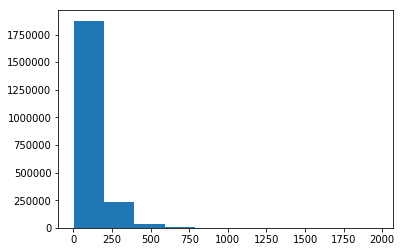

In [62]:
import matplotlib.pyplot as plt
plt.hist(sorted(lengths)[:-20])

In [65]:
n_under_20 = sum([1 if l < 20 else 0 for l in lengths])
print(n_under_20, "out of", len(lengths), "({}\%)".format(float(n_under_20)/len(lengths)))

203512 out of 2156054 (0.09439095681277\%)
